In [1]:
# kaggle competitions submit -c [COMPETITION] -f [FILE] -m [MESSAGE]: make a competition submission


In [2]:
import pyarrow.parquet as pa
import pandas as pd



In [3]:
tbl = pa.read_table('jane-street-real-time-market-data-forecasting/train.parquet/partition_id=0/part-0.parquet').to_pandas()

In [4]:
# schema = pa.read_schema('jane-street-real-time-market-data-forecasting/lags.parquet/date_id=0/part-0.parquet')
# tbllags = pa.read_table('jane-street-real-time-market-data-forecasting/lags.parquet/date_id=0/part-0.parquet', schema=schema).to_pandas()

In [5]:
#symbol : financial instrument (20 in the parquet)
# Transformer - input - seq of n instruments, window (60) * n features, to predict outcome of each instrument
# embedding of window * n features (60 * 100) to a fixed size vector (1024)

# VAR model

In [6]:

tbl['symbol_id'].value_counts()

symbol_id
1     143481
16    141783
7     140934
19    139236
9     138387
0     138387
38    133293
33    115464
12    112068
13    110370
8     108672
10    102729
2      73863
17     68769
34     61128
3      60279
11     58581
14     54336
15     22074
30     20376
Name: count, dtype: int64

#### Drop columns with NA

In [7]:
# 78 features, 8 targets
# dropped 9 columns
drop_threshold = 0.5
print((tbl.isna().sum() <tbl.shape[0]*drop_threshold).sum(), tbl.shape[1])


84 93


In [ ]:
from sklearn.preprocessing import MinMaxScaler

def preprocess(df, drop_threshold = 0.5):
    '''preprocess DF:
     1) remove NA
     2) add continuous datetime variable
     3) add day parameter 
     4) add lagged variables
     5) Drop responders
        6) Drop date_id, time_id, symbol_id
    '''
    tbl = df.copy()
    tbl = tbl[tbl.columns[tbl.isna().sum() <tbl.shape[0]*drop_threshold]] 
    tbl['t'] = (tbl['date_id'].astype(str) + tbl['time_id'].astype(str)) #.astype(int) ### Big issue here
    tbl['day'] = tbl['date_id'] % 5
    floats = tbl.select_dtypes(include='float').diff()
    floats.columns = {"".join([col,"_l1"]) for col in floats.columns}
    responder = tbl['responder_6']
    tbl.drop(columns = ['responder_0','responder_1','responder_2','responder_3','responder_4','responder_5','responder_6','responder_7', 'responder_8'], inplace = True)
    tbl = pd.concat([tbl,floats], axis = 1).iloc[1:]
    # scaler = MinMaxScaler()
    # scaled_tbl = pd.DataFrame( scaler.fit_transform(df), columns=df.columns)

    #minmax scaling
    return tbl, responder
X, Y = preprocess(tbl)

In [21]:
X.isna().sum().sum()

6732192

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader, Subset, TensorDataset
cutoff = -100000
train_dataset = TensorDataset(torch.tensor(X[:cutoff].values), torch.tensor(Y[:cutoff].values))
val_dataset = TensorDataset(torch.tensor(X[cutoff:].values), torch.tensor(Y[cutoff:].values))
bs =2048
trainloader = DataLoader(train_dataset, batch_size=bs, shuffle=False)
valloader = DataLoader(val_dataset, batch_size=bs, shuffle=False)

#### Stationarity
Symbol 0:
almost all are nonstationary at some point in time -> we should difference all and append

In [10]:
# should add lags of time (to show gap in time)
# consider the lags issue by adding lags of responders
selected = tbl.loc[tbl['symbol_id'] == 1] #.loc[ tbl['date_id']==1]
selected_f =selected['feature_70']
selected_t = selected['t']
window = (0, 1000)

KeyError: 't'

#### ADF (Manual)

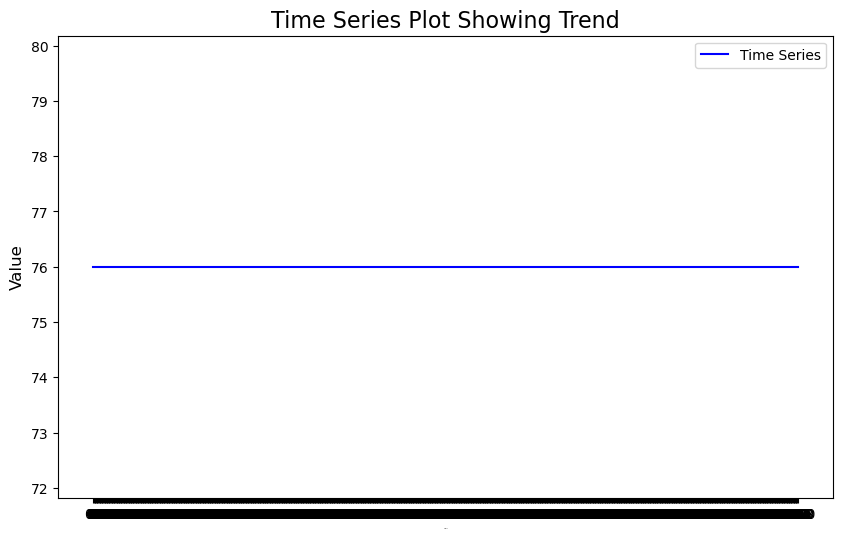

In [52]:
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
plt.figure(figsize=(10, 6))
plt.plot(selected_t[window[0]:window[1]], selected_f[window[0]:window[1]], label="Time Series", color="blue")
plt.title("Time Series Plot Showing Trend", fontsize=16)
plt.xlabel("Time", fontsize=0)
plt.ylabel("Value", fontsize=12)
plt.legend()
plt.grid(False)
plt.show()

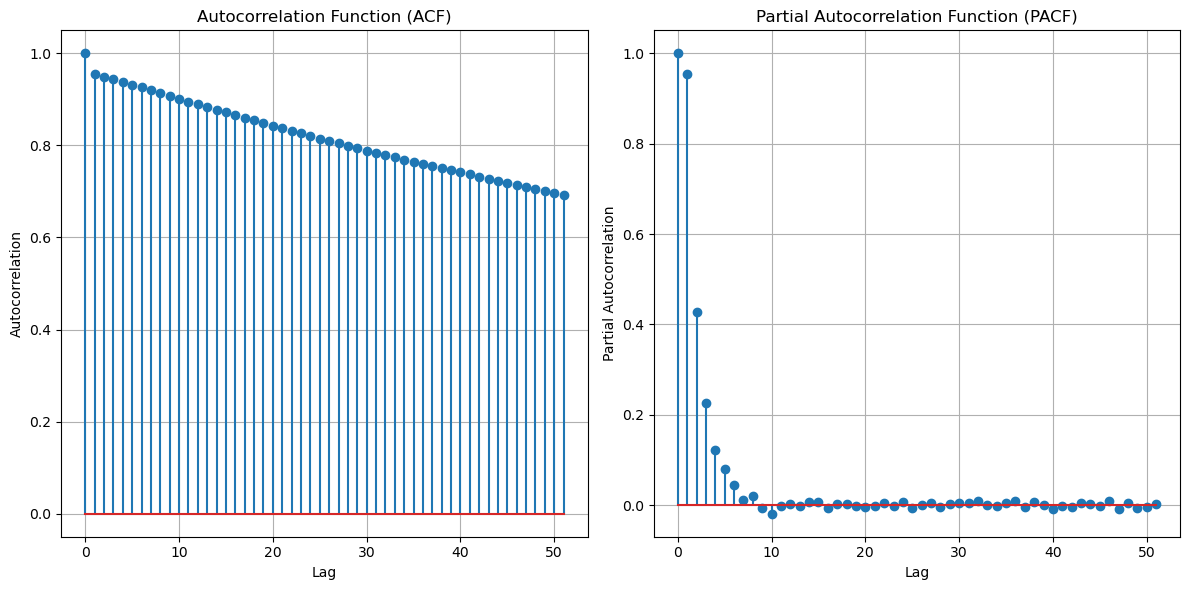

In [43]:
from statsmodels.tsa.stattools import acf, pacf
acf_values = acf(selected_f)
pacf_values = pacf(selected_f)
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot ACF
ax[0].stem(range(len(acf_values)), acf_values)
ax[0].set_title("Autocorrelation Function (ACF)")
ax[0].set_xlabel("Lag")
ax[0].set_ylabel("Autocorrelation")
ax[0].grid()

# Plot PACF
ax[1].stem(range(len(pacf_values)), pacf_values)
ax[1].set_title("Partial Autocorrelation Function (PACF)")
ax[1].set_xlabel("Lag")
ax[1].set_ylabel("Partial Autocorrelation")
ax[1].grid()

plt.tight_layout()
plt.show()

In [ ]:
def stationarity(df, threshold=0.1):
    results = {}
    # Filter only numeric columns
    numeric_df = df.select_dtypes(include='number')
    
    for col in numeric_df.columns:
        original_var = numeric_df[col].var()
        differenced_var = numeric_df[col].diff().var()
        results[col] = (differenced_var / original_var) < threshold
    
    return results
# stationarity(selected)

1              00
2              00
3              00
4              00
5              00
            ...  
1944205    169848
1944206    169848
1944207    169848
1944208    169848
1944209    169848
Name: t, Length: 1944209, dtype: object

In [22]:
X.drop(columns = ['t'], inplace = True)

1              00
2              00
3              00
4              00
5              00
            ...  
1944205    169848
1944206    169848
1944207    169848
1944208    169848
1944209    169848
Name: t, Length: 1944209, dtype: object

In [17]:

from sklearn.model_selection import TimeSeriesSplit
import torch
import numpy as np

TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint8, and bool.

In [ ]:
# tscv = TimeSeriesSplit(n_splits=5, test_size = X.shape[0]//200)
# combine the indices for the 5 splits into one for train and val, and initialize ONE dataloader

In [ ]:
X.shape

(1944210, 84)

In [ ]:
X.shape

(1944210, 84)

In [ ]:
train_idx.shape

(1895605,)

In [ ]:
train_subset = Subset(dataset, tscv.split(X)[0][0])